> ![](https://raw.githubusercontent.com/SunnySuite/Sunny.jl/main/assets/sunny_logo.jpg)
_This is a
 [tutorial](https://github.com/SunnySuite/SunnyTutorials/)
 for the [Sunny](https://github.com/SunnySuite/Sunny.jl/) package, which
 enables dynamical simulations of ordered and thermally disordered spins with
 dipole and higher order moments._

# Spin Dynamics of the Heisenberg pyrochlore antiferromagnet and applications to MgCr2O4
**Author**: Martin Mourigal <br>
**Date**: September 9, 2022 (Updated by David Dahlbom on April 17, 2023) <br>


In this tutorial, we will walk through a first example in Sunny and calculate
the spin dynamical properties of the Heisenberg pyrochlore antiferromagnet and
apply this knowledge to MgCr2O4 and ZnCr2O4, which are known to approximate
this model. Relevant publications include:

[1] P. H. Conlon and J. T. Chalker, Phys. Rev. Lett. 102, 237206 (2009)
(https://doi.org/10.1103/PhysRevLett.102.237206)

[2] P. H. Conlon and J. T. Chalker, Phys. Rev. B 81, 224413 (2010)
(https://doi.org/10.1103/PhysRevB.81.224413)

[3] X. Bai, J. A. M. Paddison, _et al._ Phys. Rev. Lett. 122, 097201 (2019)
(https://doi.org/10.1103/PhysRevLett.122.097201)

## Setting up Julia
To run the examples in the tutorial, you will need a working installation of
the Julia programming language and the Sunny package. Some useful references
for getting started are:

https://github.com/SunnySuite/Sunny.jl/wiki/Getting-started-with-Julia-and-Sunny

https://sunnysuite.github.io/Sunny.jl/dev/

We will begin by loading the relevant packages.

In [1]:
using Sunny # The main package
using GLMakie # Plotting package
Sunny.offline_viewers(); # Enable Javascript plotting
Makie.inline!(true); # Embed Makie plots in notebook
cif_path = joinpath("..", "Sunny.jl", "examples", "longer_examples");

## Setting up the crystal structure

Before specifying the interactions of our system, we first must set up the
crystal. We will begin by specifying the pyrochlore lattice (illustrated
below) in the manner that is typical of theorists.

![](https://www.oist.jp/sites/default/files/photos/20200110-diagram-of-pyrochlore-lattice.jpg)

_Picture Credits: Theory of Quantum Matter Unit, OIST_

### "Theorist" Method

In this approach, we directly define the lattice vectors and specify the position
of each atom in fractional coordinates.

In [2]:
latvecs = lattice_vectors(8.3342, 8.3342, 8.3342, 90, 90, 90);
positions = [[0.875, 0.625, 0.375],
             [0.625, 0.125, 0.625],
             [0.875, 0.875, 0.125],
             [0.625, 0.875, 0.375],
             [0.875, 0.125, 0.875],
             [0.625, 0.625, 0.125],
             [0.875, 0.375, 0.625],
             [0.625, 0.375, 0.875],
             [0.375, 0.625, 0.875],
             [0.125, 0.125, 0.125],
             [0.375, 0.875, 0.625],
             [0.125, 0.875, 0.875],
             [0.375, 0.125, 0.375],
             [0.125, 0.625, 0.625],
             [0.375, 0.375, 0.125],
             [0.125, 0.375, 0.375]];
types = ["B" for _ in positions]
xtal_pyro   = Crystal(latvecs, positions; types) # We will call this crystal the Theoretical Pyrochlore

Crystal
HM symbol 'F d -3 m' (227)
Lattice params a=8.334, b=8.334, c=8.334, α=90°, β=90°, γ=90°
Cell volume 578.9
Type 'B', Wyckoff 16c (point group '.-3m'):
   1. [0.875, 0.625, 0.375]
   2. [0.625, 0.125, 0.625]
   3. [0.875, 0.875, 0.125]
   4. [0.625, 0.875, 0.375]
   5. [0.875, 0.125, 0.875]
   6. [0.625, 0.625, 0.125]
   7. [0.875, 0.375, 0.625]
   8. [0.625, 0.375, 0.875]
   9. [0.375, 0.625, 0.875]
   10. [0.125, 0.125, 0.125]
   11. [0.375, 0.875, 0.625]
   12. [0.125, 0.875, 0.875]
   13. [0.375, 0.125, 0.375]
   14. [0.125, 0.625, 0.625]
   15. [0.375, 0.375, 0.125]
   16. [0.125, 0.375, 0.375]


To examine the result interactively, we can call `view_crystal`.

In [3]:
view_crystal(xtal_pyro, 3.2)

SunnyViewer(...)

### "Experimentalist" Method #1 (Incorrect)
A real crystal is more complicated than this, however, and we will now
construct the system using the actual CIF file of MgCr2O4 from ICSD. This can
be done by copying over the data from a CIF file by hand, but this can be
dangerous, as shown below.

In [4]:
latvecs   = lattice_vectors(8.3342, 8.3342, 8.3342, 90, 90, 90)
positions = [[0.1250, 0.1250, 0.1250],
             [0.5000, 0.5000, 0.5000],
             [0.2607, 0.2607, 0.2607]]
types = ["Mg","Cr","O"]
xtal_mgcro_1 = Crystal(latvecs, positions; types)

Crystal
HM symbol 'R 3 m' (160)
Lattice params a=8.334, b=8.334, c=8.334, α=90°, β=90°, γ=90°
Cell volume 578.9
Type 'Mg', Wyckoff 3a (point group '3m'):
   1. [0.125, 0.125, 0.125]
Type 'Cr', Wyckoff 3a (point group '3m'):
   2. [0.5, 0.5, 0.5]
Type 'O', Wyckoff 3a (point group '3m'):
   3. [0.2607, 0.2607, 0.2607]


Sunny returned a valid crystal, but it did get right space group for MgCr2O4.
This can be fixed by modifying the input to include the space group and the
setting.

### "Experimentalist" Method #2 (Correct)

As above, we will define the crystal structure of MgCr2O4 by copying the info
from a CIF file, but we will also specify the space group and setting
explicitly.

In [5]:
latvecs    = lattice_vectors(8.3342, 8.3342, 8.3342, 90, 90, 90)
positions  = [[0.1250, 0.1250, 0.1250],
              [0.5000, 0.5000, 0.5000],
              [0.2607, 0.2607, 0.2607]]
types      = ["Mg","Cr","O"]
spacegroup = 227 # Space Group Number
setting    = "2" # Space Group setting
xtal_mgcro_2 = Crystal(latvecs, positions, spacegroup; types, setting)

Crystal
HM symbol 'F d -3 m' (227)
Lattice params a=8.334, b=8.334, c=8.334, α=90°, β=90°, γ=90°
Cell volume 578.9
Type 'Mg', Wyckoff 8b (point group '-43m'):
   1. [0.125, 0.125, 0.125]
   2. [0.625, 0.625, 0.125]
   3. [0.875, 0.375, 0.375]
   4. [0.375, 0.875, 0.375]
   5. [0.625, 0.125, 0.625]
   6. [0.125, 0.625, 0.625]
   7. [0.375, 0.375, 0.875]
   8. [0.875, 0.875, 0.875]
Type 'Cr', Wyckoff 16c (point group '.-3m'):
   9. [0.5, 0, 0]
   10. [0.75, 0.25, 0]
   11. [0, 0.5, 0]
   12. [0.25, 0.75, 0]
   13. [0.75, 0, 0.25]
   14. [0.5, 0.25, 0.25]
   15. [0.25, 0.5, 0.25]
   16. [0, 0.75, 0.25]
   17. [0, 0, 0.5]
   18. [0.25, 0.25, 0.5]
   19. [0.5, 0.5, 0.5]
   20. [0.75, 0.75, 0.5]
   21. [0.25, 0, 0.75]
   22. [0, 0.25, 0.75]
   23. [0.75, 0.5, 0.75]
   24. [0.5, 0.75, 0.75]
Type 'O', Wyckoff 32e (point group '.3m'):
   25. [0.7393, 0.0107, 0.0107]
   26. [0.5107, 0.2393, 0.0107]
   27. [0.2393, 0.5107, 0.0107]
   28. [0.0107, 0.7393, 0.0107]
   29. [0.5107, 0.0107, 0.2393]
  

This result is correct, but at this point we might as well import the CIF file
directly, which we now proceed to do.

### "Experimentalist" Method #3 (Correct -- if your CIF file is)

To import a CIF file, simply give the path to `Crystal`. One may optionally
specify a precision parameter to apply to the symmetry analysis.

In [6]:
xtal_mgcro_3 = Crystal(joinpath(cif_path, "MgCr2O4_160953_2009.cif"); symprec=0.001)

Crystal
HM symbol 'F d -3 m' (227)
Lattice params a=8.333, b=8.333, c=8.333, α=90°, β=90°, γ=90°
Cell volume 578.6
Type 'Mg1', Wyckoff 8b (point group '-43m'):
   1. [0.125, 0.125, 0.125]
   2. [0.625, 0.625, 0.125]
   3. [0.875, 0.375, 0.375]
   4. [0.375, 0.875, 0.375]
   5. [0.625, 0.125, 0.625]
   6. [0.125, 0.625, 0.625]
   7. [0.375, 0.375, 0.875]
   8. [0.875, 0.875, 0.875]
Type 'Cr1', Wyckoff 16c (point group '.-3m'):
   9. [0.5, 0, 0]
   10. [0.75, 0.25, 0]
   11. [0, 0.5, 0]
   12. [0.25, 0.75, 0]
   13. [0.75, 0, 0.25]
   14. [0.5, 0.25, 0.25]
   15. [0.25, 0.5, 0.25]
   16. [0, 0.75, 0.25]
   17. [0, 0, 0.5]
   18. [0.25, 0.25, 0.5]
   19. [0.5, 0.5, 0.5]
   20. [0.75, 0.75, 0.5]
   21. [0.25, 0, 0.75]
   22. [0, 0.25, 0.75]
   23. [0.75, 0.5, 0.75]
   24. [0.5, 0.75, 0.75]
Type 'O1', Wyckoff 32e (point group '.3m'):
   25. [0.7388, 0.0112, 0.0112]
   26. [0.5112, 0.2388, 0.0112]
   27. [0.2388, 0.5112, 0.0112]
   28. [0.0112, 0.7388, 0.0112]
   29. [0.5112, 0.0112, 0.2388]

Finally, we wish to restrict attention to the magnetic atoms in the unit cell
while maintaining symmetry information for the full crystal, which is required
to determine the correct exchange and g-factor anisotropies. This can be
achieved with the `subcrystal` function.

In [7]:
xtal_mgcro = subcrystal(xtal_mgcro_2,"Cr")

Crystal
HM symbol 'F d -3 m' (227)
Lattice params a=8.334, b=8.334, c=8.334, α=90°, β=90°, γ=90°
Cell volume 578.9
Type 'Cr', Wyckoff 16c (point group '.-3m'):
   1. [0.5, 0, 0]
   2. [0.75, 0.25, 0]
   3. [0, 0.5, 0]
   4. [0.25, 0.75, 0]
   5. [0.75, 0, 0.25]
   6. [0.5, 0.25, 0.25]
   7. [0.25, 0.5, 0.25]
   8. [0, 0.75, 0.25]
   9. [0, 0, 0.5]
   10. [0.25, 0.25, 0.5]
   11. [0.5, 0.5, 0.5]
   12. [0.75, 0.75, 0.5]
   13. [0.25, 0, 0.75]
   14. [0, 0.25, 0.75]
   15. [0.75, 0.5, 0.75]
   16. [0.5, 0.75, 0.75]


## Making a `System` and assigning interactions
### Making a `System`
Before assigning any interactions, we first have to set up a `System` using
our `Crystal`.

In [8]:
dims = (6, 6, 6)  # Supercell dimensions
spininfos = [SpinInfo(1; S=3/2)]  # Specify spin information, note that all sites are symmetry equivalent
sys_pyro = System(xtal_pyro, dims, spininfos, :dipole)    # Make a system in dipole (Landau-Lifshitz) mode on pyrochlore lattice
sys_mgcro = System(xtal_mgcro, dims, spininfos, :dipole); # Same on MgCr2O4 crystal

To understand what interactions we may assign to this system, we have to
understand the the symmetry properties of the crystal, which we turn to next.

### Symmetry analysis for exchange and single-ion anisotropies

`print_symmetry_table` reports all the exchange interactions, single-site
anisotropies, and g-factors allowed on our crystal. It takes a `Cyrstal` and a
distance. We'll look at both the "theorist's" pyrochlore lattice,

In [9]:
print_symmetry_table(xtal_pyro, 5.9)

Atom 1
Type 'B', position [0.875, 0.625, 0.375], multiplicity 16
Allowed g-tensor: | A  B -B |
                  | B  A  B |
                  |-B  B  A |
Allowed anisotropy in Stevens operators 𝒪[k,q]:
    c₁*(𝒪[2,-2]+2𝒪[2,-1]-2𝒪[2,1]) +
    c₂*(7𝒪[4,-3]+2𝒪[4,-2]-𝒪[4,-1]+𝒪[4,1]+7𝒪[4,3]) + c₃*(𝒪[4,0]+5𝒪[4,4]) +
    c₄*(-11𝒪[6,-6]-8𝒪[6,-3]+𝒪[6,-2]-8𝒪[6,-1]+8𝒪[6,1]-8𝒪[6,3]) + c₅*(𝒪[6,0]-21𝒪[6,4]) + c₆*((9/5)𝒪[6,-6]+(24/5)𝒪[6,-5]+𝒪[6,-2]+(8/5)𝒪[6,-1]-(8/5)𝒪[6,1]-(24/5)𝒪[6,5])

Sunny.Bond(1, 3, [0, 0, 0])
Distance 2.94658466788246, coordination 6
Connects 'B' at [0.875, 0.625, 0.375] to 'B' at [0.875, 0.875, 0.125]
Allowed exchange matrix: | A -D  D |
                         | D  B  C |
                         |-D  C  B |
Allowed DM vector: [0 -D -D]

Sunny.Bond(1, 2, [0, 0, 0])
Distance 5.10363435357589, coordination 12
Connects 'B' at [0.875, 0.625, 0.375] to 'B' at [0.625, 0.125, 0.625]
Allowed exchange matrix: |   A  C-E  D-F |
                         | C+E    B -C+E |
             

and for the the MgCrO4 crystal,

In [10]:
print_symmetry_table(xtal_mgcro, 6.0)

Atom 1
Type 'Cr', position [0.5, 0, 0], multiplicity 16
Allowed g-tensor: | A  B  B |
                  | B  A  B |
                  | B  B  A |
Allowed anisotropy in Stevens operators 𝒪[k,q]:
    c₁*(𝒪[2,-2]+2𝒪[2,-1]+2𝒪[2,1]) +
    c₂*(-7𝒪[4,-3]-2𝒪[4,-2]+𝒪[4,-1]+𝒪[4,1]+7𝒪[4,3]) + c₃*(𝒪[4,0]+5𝒪[4,4]) +
    c₄*(-11𝒪[6,-6]-8𝒪[6,-3]+𝒪[6,-2]-8𝒪[6,-1]-8𝒪[6,1]+8𝒪[6,3]) + c₅*(𝒪[6,0]-21𝒪[6,4]) + c₆*((9/5)𝒪[6,-6]+(24/5)𝒪[6,-5]+𝒪[6,-2]+(8/5)𝒪[6,-1]+(8/5)𝒪[6,1]+(24/5)𝒪[6,5])

Sunny.Bond(1, 2, [0, 0, 0])
Distance 2.94658466788246, coordination 6
Connects 'Cr' at [0.5, 0, 0] to 'Cr' at [0.75, 0.25, 0]
Allowed exchange matrix: | A  C -D |
                         | C  A -D |
                         | D  D  B |
Allowed DM vector: [-D D 0]

Sunny.Bond(1, 7, [0, 0, 0])
Distance 5.10363435357589, coordination 12
Connects 'Cr' at [0.5, 0, 0] to 'Cr' at [0.25, 0.5, 0.25]
Allowed exchange matrix: |   A  C-E  D-F |
                         | C+E    B -C+E |
                         | D+F -C-E    A |
Allow

Note that the exchange anisotropies allowed on the the pyrochlore lattice are
slightly different from those on the MgCr2O4 cyrstal due to the role of Mg
and O in the bonds. Also note that Sunny has correctly identified the two
inequivalent bonds 3a and 3b having the same length. A question may arises to
know which bond is J3a and which is J3b, let's plot the structure.

In [11]:
view_crystal(xtal_mgcro, 5.9)

SunnyViewer(...)

The crystal viewer shows that the second interaction -- cyan color with
distance of 5.89Å -- is in fact the one hopping through a chromium site,
meaning it is J3a! We will need to be careful with that later.

### Building the exchange interactions for our system

We begin by setting the scale of our exchange interactions on each bond.

In [12]:
J1      = 3.27  # value of J1 in meV from Bai's PRL paper
J_pyro  = [1.00,0.000,0.000,0.000]*J1    # pure nearest neighbor pyrochlore
J_mgcro = [1.00,0.0815,0.1050,0.085]*J1; # further neighbor pyrochlore relevant for MgCr2O4
# val_J_mgcro = [1.00,0.000,0.025,0.025]*val_J1; # this is a funny setting from Conlon-Chalker

These values are then assigned to their corresponding bonds with `set_exchange!`.

In [13]:
# === Assign exchange interactions to pyrochlore system ===
set_exchange!(sys_pyro, J_pyro[1], Bond(1, 3, [0,0,0])) # J1
set_exchange!(sys_pyro, J_pyro[2], Bond(1, 2, [0,0,0])) # J2
set_exchange!(sys_pyro, J_pyro[3], Bond(2, 6, [0,0,0])) # J3a
set_exchange!(sys_pyro, J_pyro[4], Bond(1, 5, [0,0,0])) # J3b

# === Assign exchange interactions to MgCr2O4 system ===
set_exchange!(sys_mgcro, J_mgcro[1], Bond(1, 2, [0,0,0]))  # J1
set_exchange!(sys_mgcro, J_mgcro[2], Bond(1, 7, [0,0,0]))  # J2
set_exchange!(sys_mgcro, J_mgcro[3], Bond(1, 3, [0,0,0]))  # J3a -- Careful here!
set_exchange!(sys_mgcro, J_mgcro[4], Bond(1, 3, [1,0,0])); # J3b -- And here!

We will not be assigning any single-ion anisotropies, so we have finished
specifying our models. For good measure, we will set both systems to a random
(infinite temperature) initial condition.

In [14]:
randomize_spins!(sys_pyro)
randomize_spins!(sys_mgcro)

## Cooling our `System` amd calculating the instantaneous and dynamic structure factors at the final temperature ##

We begin by thermalizing our system at a particular temperature. We will
accomplish this by running Langevin dynamics. To do this, we must set up a
Langevin integrator.

In [15]:
Δt = 0.05  # Integration time step in meV^-1
λ  = 0.1   # Phenomenological damping parameter
kT = 1.8   # Desired temperature in meV
langevin = Langevin(Δt; λ, kT); # Construct integrator

We can now thermalize our systems by running the integrator.

In [16]:
for _ in 1:2000
    step!(sys_pyro, langevin)
    step!(sys_mgcro, langevin)
end

As a sanity check, we'll plot the real-space spin configurations of both
systems after themalization. First the pyrochlore,

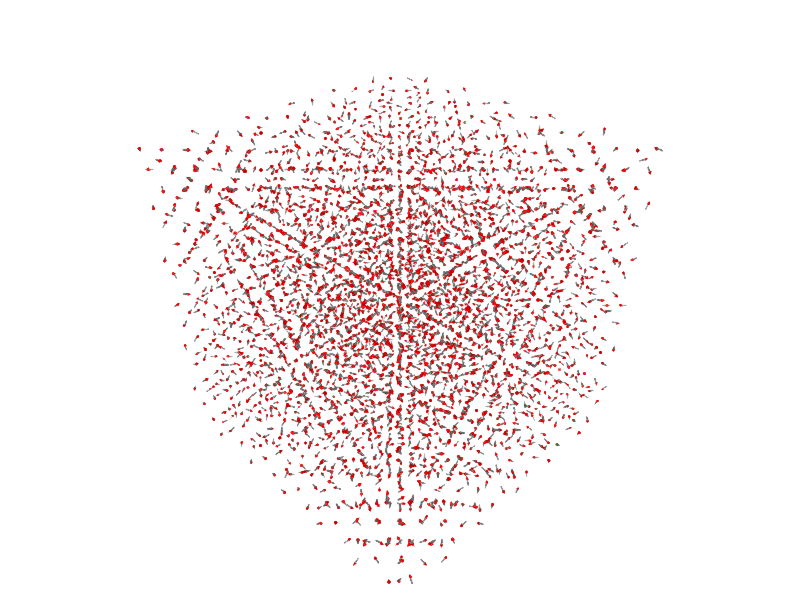

In [17]:
plot_spins(sys_pyro; arrowlength=0.5, linewidth=0.2, arrowsize=0.5)

and then the MgCr2O4,

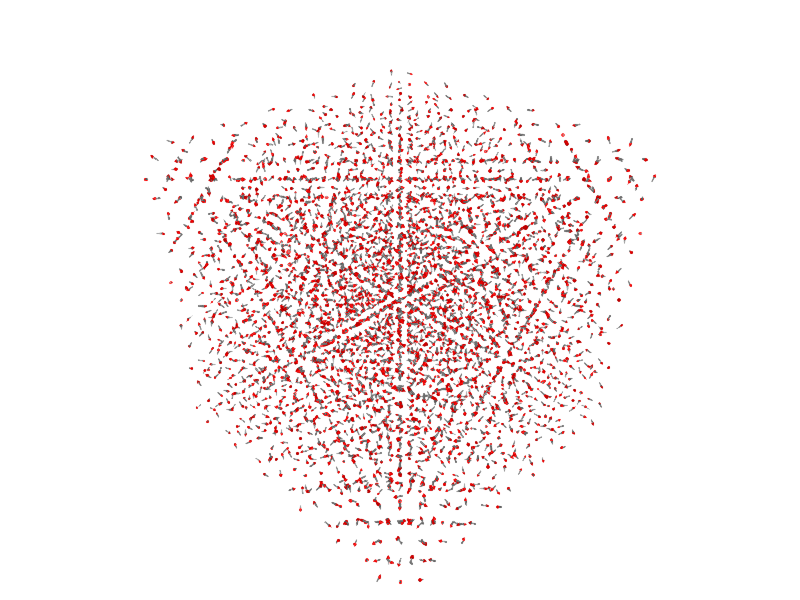

In [18]:
plot_spins(sys_mgcro; arrowlength=0.5, linewidth=0.2, arrowsize=0.5)

## Instantaneous Structure Factor
Next we can examine the instantaneous structure factor.

In [19]:
isf_pyro  = InstantStructureFactor(sys_pyro)
isf_mgcro = InstantStructureFactor(sys_mgcro);

This generates a single sample. Let's add 10 more.

In [20]:
for _ in 1:10
    # Run dynamics to decorrelate
    for _ in 1:500
        step!(sys_pyro, langevin)
        step!(sys_mgcro, langevin)
    end
    # Add samples
    add_sample!(isf_pyro, sys_pyro)
    add_sample!(isf_mgcro, sys_mgcro)
end

To retrieve the intensities, we call `intensities` on an array of wave vectors.

In [21]:
qvals = -4.0:0.025:4.0
qs = [(qa, qb, 0) for qa in qvals, qb in qvals]      # Wave vectors to query

Sq_pyro  = instant_intensities(isf_pyro, qs, :perp)  # :perp applies polarization factor
Sq_mgcro = instant_intensities(isf_mgcro, qs, :perp);

Finally, we can plot the results.

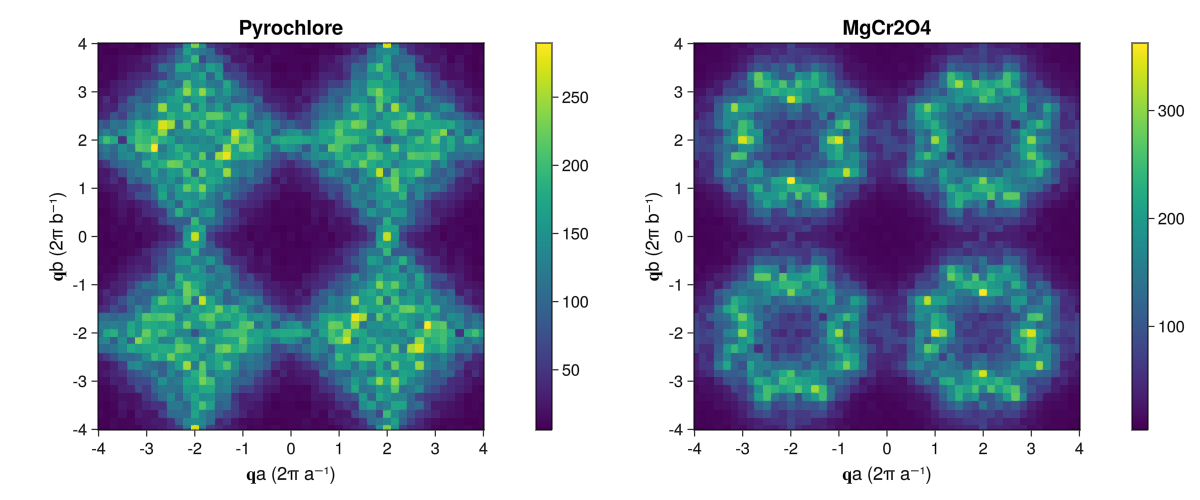

In [22]:
fig = Figure(; resolution=(1200,500))
axparams = (aspect = true, xticks=-4:4, yticks=-4:4, titlesize=20,
    xlabel = "𝐪a (2π a⁻¹)", ylabel = "𝐪b (2π b⁻¹)", xlabelsize = 18, ylabelsize=18,)
ax_pyro  = Axis(fig[1,1]; title="Pyrochlore", axparams...)
ax_mgcro = Axis(fig[1,3]; title="MgCr2O4",  axparams...)
hm = heatmap!(ax_pyro, qvals, qvals, Sq_pyro)
Colorbar(fig[1,2], hm)
hm = heatmap!(ax_mgcro, qvals, qvals, Sq_mgcro)
Colorbar(fig[1,4], hm)
fig

## Dynamical Structure Factor
We can also calculate the dynamical structure factor.

In [23]:
dsf_pyro  = DynamicStructureFactor(sys_pyro;  Δt, ωmax = 10.0, nω = 100)
dsf_mgcro = DynamicStructureFactor(sys_mgcro; Δt, ωmax = 10.0, nω = 100);

One sample is calculated when creating a `DynamicStructureFactor`. Let's add a
couple more.

In [24]:
for _ in 1:2
    # Run dynamics to decorrelate
    for _ in 1:500
        step!(sys_pyro, langevin)
        step!(sys_mgcro, langevin)
    end
    # Add samples
    add_sample!(dsf_pyro, sys_pyro)
    add_sample!(dsf_mgcro, sys_mgcro)
end

We can now examine the structure factor intensities along a path in momentum space.

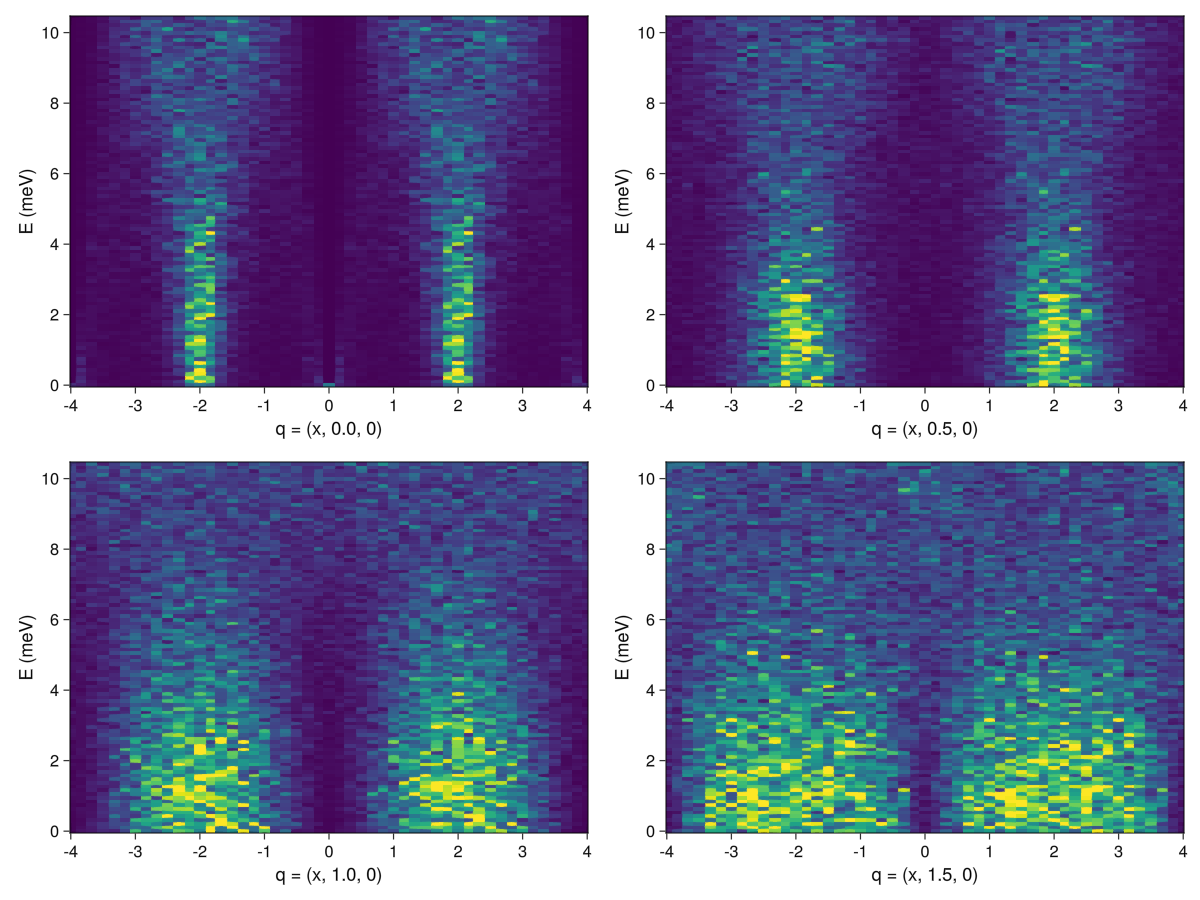

In [25]:
fig = Figure(; resolution=(1200,900))
axsqw = (xticks=-4:4, yticks=0:2:10, ylabel="E (meV)", ylabelsize=18, xlabelsize=18, )

qbs = 0.0:0.5:1.5 # Determine q_b for each slice
for (i, qb) in enumerate(qbs)
    path, labels = connected_path([[-4.0, qb, 0.0],[4.0, qb, 0.0]], 40)  # Generate a path of wave
                                                                         # vectors through the BZ
    Sqω_pyro  = intensities(dsf_pyro, path, :perp; kT)  # Temperature keyword enables intensity rescaling

    ax = Axis(fig[fldmod1(i,2)...]; xlabel = "q = (x, $qb, 0)", axsqw...)
    heatmap!(ax, [p[1] for p in path], ωs(dsf_pyro), Sqω_pyro; colorrange=(0.0, 4.0))
end
fig

And let's take a look at the same slices for MgCr2O4.

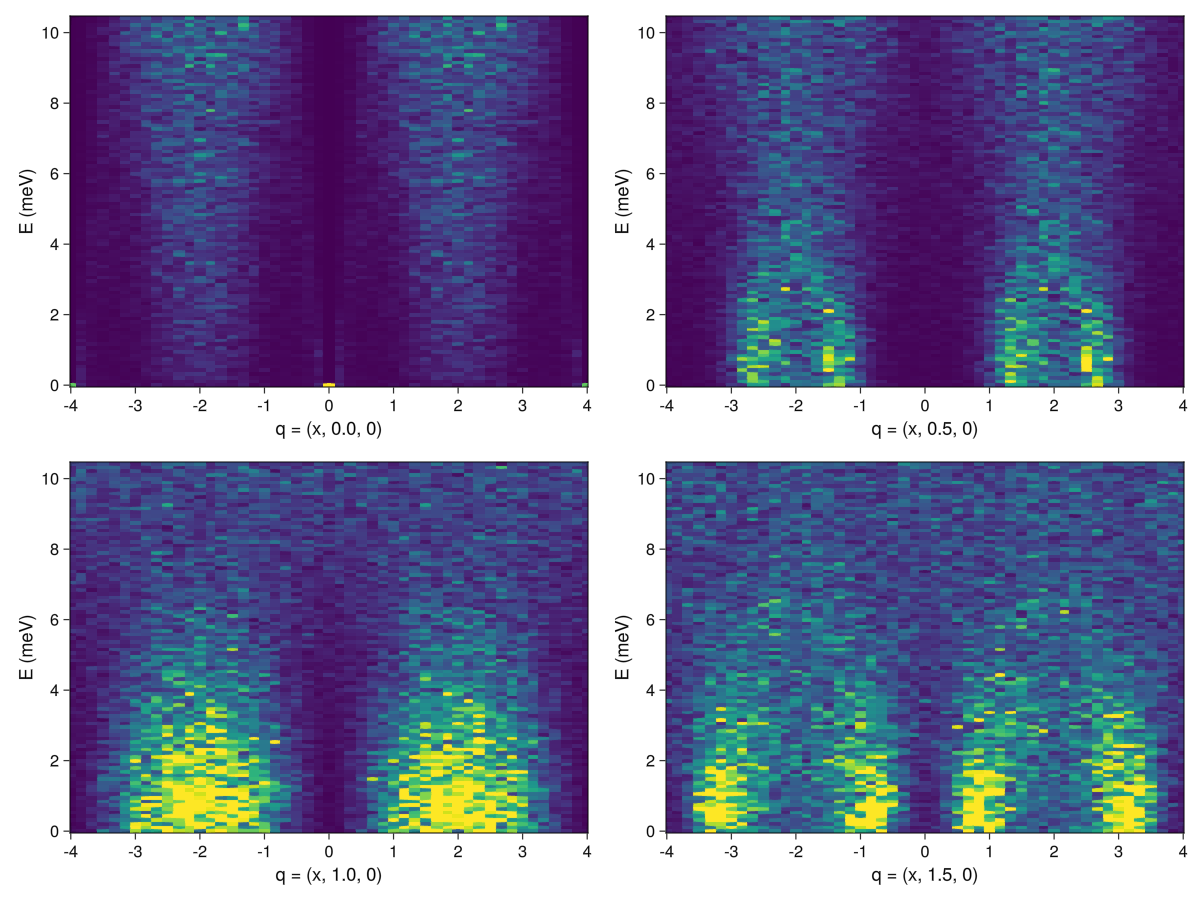

In [26]:
fig = Figure(; resolution=(1200,900))

qbs = 0.0:0.5:1.5
for (i, qb) in enumerate(qbs)
    path, labels = connected_path([[-4.0, qb, 0.0],[4.0, qb, 0.0]], 40)  # Generate a path of wave
                                                                         # vectors through the BZ
    Sqω_mgcro  = intensities(dsf_mgcro, path, :perp; kT)  # Temperature keyword enables intensity rescaling

    ax = Axis(fig[fldmod1(i,2)...]; xlabel = "q = (x, $qb, 0)", axsqw...)
    heatmap!(ax, [p[1] for p in path], ωs(dsf_mgcro), Sqω_mgcro; colorrange=(0.0, 4.0))
end
fig

### Instantaneous structure factor from a dynamical structure factor

Finally, we note that the instant structure factor can be calculated from the
dynamical structure factor. We simply call `instant_intensities` rather than
`intensities`. This will calculate the instantaneous structure factor from
from $𝒮(𝐪,ω)$ by integrating out $ω$ . An advantage of doing this (as
opposed to using an `InstantStructureFactor`) is that Sunny is able to apply a
temperature- and energy-dependent intensity rescaling before integrating out
the dynamical information. The results of this approach are more suitable for
comparison with experimental data.

In [27]:
qvals = -4.0:0.05:4.0
qs = [(qa, qb, 0) for qa in qvals, qb in qvals]      # Wave vectors to query

Sq_pyro  = instant_intensities(dsf_pyro, qs, :perp; kT)
Sq_mgcro = instant_intensities(dsf_mgcro, qs, :perp; kT);

We can plot the results below. It is useful to compare these to the plot above
generated with an `InstantStructureFactor`.

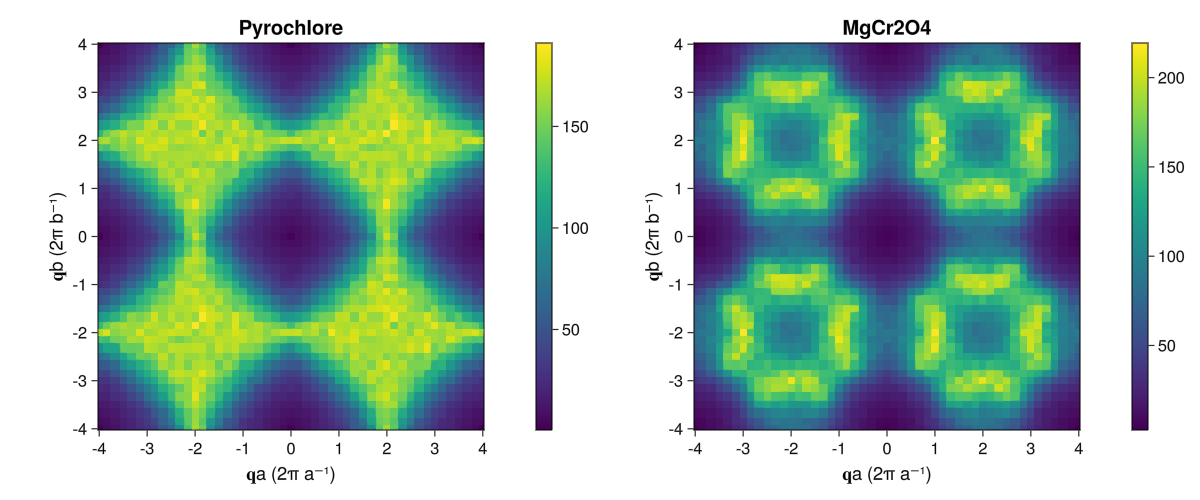

In [28]:
fig = Figure(; resolution=(1200,500))
ax_pyro  = Axis(fig[1,1]; title="Pyrochlore", axparams...)
ax_mgcro = Axis(fig[1,3]; title="MgCr2O4", axparams...)
hm = heatmap!(ax_pyro, qvals, qvals, Sq_pyro)
Colorbar(fig[1,2], hm)
hm = heatmap!(ax_mgcro, qvals, qvals, Sq_mgcro)
Colorbar(fig[1,4], hm)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*